In [1]:
'''
数据集：
训练集不作修改，黑底；测试集白底基础上随机着色

模型架构：
LeNet5
特征提取层：3,28,28->16,5,5
分类层：16*5*5->2

算法：
IRM-RSC结合，总损失L_total=L_ERM+\ lambda*Ω_IRM
L_ERM的前向传播过程遵循RSC算法

模型超参数：
drop_rate：要抑制的比例
pecent：掩码修正阶段取消抑制的比例
抑制策略的选择，是通道还是空间，这里我用了硬编码
irm_lambda：irm损失中惩罚项的权重
其他：优化器、学习率、batch_size等
'''
config={
    "drop_rate":0.05,
    "pecent":0.1,
    "irm_lambda":0.3,
    "batch_size":64,
    "lr":1e-2,
    "num_epochs":20
}

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils
import random


<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
C:\Users\XRXRX\AppData\Local\Temp\ipykernel_32636\1354597994.py:1: SyntaxWarning: invalid escape sequence '\ '
  '''


In [2]:
def color_grayscale_arr(arr, forground_color, background_color):
    """Converts grayscale image"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])#增加一个“通道”维度
    if background_color == "black":
        if forground_color == "red":
            arr = np.concatenate([arr,
                              np.zeros((h, w, 2), dtype=dtype)], axis=2)#创建全零数组作为绿色和蓝色通道，表示全红色
        elif forground_color == "green":
            arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                              arr,
                              np.zeros((h, w, 1), dtype=dtype)], axis=2)
        elif forground_color == "white":
            arr = np.concatenate([arr, arr, arr], axis=2)
    else:
        if forground_color == "yellow":
            arr = np.concatenate([arr, arr, np.zeros((h, w, 1), dtype=dtype)], axis=2)
        else:
            arr = np.concatenate([np.zeros((h, w, 2), dtype=dtype), arr], axis=2)

        c = [255, 255, 255]
        arr[:, :, 0] = (255 - arr[:, :, 0]) / 255 * c[0]
        arr[:, :, 1] = (255 - arr[:, :, 1]) / 255 * c[1]
        arr[:, :, 2] = (255 - arr[:, :, 2]) / 255 * c[2]

    return arr


class ColoredMNIST(datasets.VisionDataset):

    def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(root, transform=transform,
                                           target_transform=target_transform)

        self.prepare_colored_mnist()
        if env in ['train1', 'train2', 'train3', 'test1', 'test2']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt',
                                               weights_only=False)
        elif env == 'all_train':
            train1_data = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt'),
                                                weights_only=False ) 
            train2_data=torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'),
                                                weights_only=False)
            train3_data=torch.load(os.path.join(self.root, 'ColoredMNIST', 'train3.pt'),
                                                weights_only=False)
            self.data_label_tuples = train1_data + train2_data + train3_data
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, train3, test1, test2, and all_train')

    def __getitem__(self, index):
        """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
        img, target = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'train3.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test1.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test2.pt')):
            print('Colored MNIST dataset already exists')
            return

        print('Preparing Colored MNIST')
        train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

        train1_set = []
        train2_set = []
        train3_set = []
        test1_set, test2_set = [], []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f'Converting image {idx}/{len(train_mnist)}')
            im_array = np.array(im)
            
            # Assign a binary label y to the image based on the digit
            binary_label = 0 if label < 5 else 1

            # Color the image according to its environment label

            if idx < 10000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "red", background_color = "black")
                train1_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 20000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "green", background_color = "black")
                train2_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 30000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "white", background_color = "black")
                train3_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 45000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "yellow", background_color = "white")
                test1_set.append((Image.fromarray(colored_arr), binary_label))
            else:
                colored_arr = color_grayscale_arr(im_array, forground_color = "blue", background_color = "white")
                test2_set.append((Image.fromarray(colored_arr), binary_label))
                
            # Image.fromarray(colored_arr).save('./data/sample/{}.png'.format(idx))

        if not os.path.exists(colored_mnist_dir):
            os.makedirs(colored_mnist_dir)
        torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
        torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
        torch.save(train3_set, os.path.join(colored_mnist_dir, 'train3.pt'))
        torch.save(test1_set, os.path.join(colored_mnist_dir, 'test1.pt'))
        torch.save(test2_set, os.path.join(colored_mnist_dir, 'test2.pt'))

class RandomColoring(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def _generate_random_color(self):
        #生成一个随机的RGB颜色元组，值在[0, 1]之间
        return (random.random(), random.random(), random.random())

    def forward(self, tensor_image: torch.Tensor) -> torch.Tensor:
        #这个变换要在ToTensor之后做，注意：ToTensor会把颜色的三通道放在第一个维度！！
       
        #识别前景和背景，黑色背景中有值的就是数字
        #从通道检查，如果该位置任意个通道有值，那它就是数字所在的位置，这将返回一个28*28的掩码数组，表示对应位置有没有数字
        foreground_mask = ~torch.all(tensor_image > 0.9, dim=0)
        background_mask=~foreground_mask
        #print(foreground_mask)

        #生成随机的前景色和背景色
        foreground_color=self._generate_random_color()
        background_color=self._generate_random_color()
        #如果颜色太近重新生成
        while torch.linalg.norm(torch.tensor(foreground_color)-torch.tensor(background_color))< 0.5:
            background_color = self._generate_random_color()

        #先创建一个用背景色填充的图像
        new_image = torch.zeros_like(tensor_image)
        new_image[0,:, :] = background_color[0]
        new_image[1,:, :] = background_color[1]
        new_image[2,:, :] = background_color[2]
        
        #在新图像上使用掩码将有数字的位置设置为前景色
        new_image[0,foreground_mask] = foreground_color[0]
        new_image[1,foreground_mask] = foreground_color[1]
        new_image[2,foreground_mask] = foreground_color[2]
        
        return new_image

test_transform=transforms.Compose([
    #transforms.Grayscale(num_output_channels=1), 
    #transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # 随机裁剪并缩放  
    
    #transforms.RandomGrayscale(p=0.1),       # 随机灰度化
    #degrees旋转角度（最大20度），translate平移的最大距离（宽度的0.1倍），shear剪切变换的角度范围
    #transforms.RandomAffine(degrees=20, translate=(0.1, 0.1),shear=10, scale=(0.9, 1.1)),  
    transforms.ToTensor(),
    RandomColoring(),
    #transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # 随机擦除，scale擦除区域的面积范围，ratio擦除区域的宽高比的范围
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    
])


Loading
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Size of train_dataset_1: 10000
Size of test_dataset_2: 15000
Dataset ColoredMNIST
    Number of datapoints: 10000
    Root location: ./data
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
torch.Size([3, 28, 28]) torch.Size([3, 28, 28])
Test1 30000
Test1 15000
Test2 15000
看一下数据集的情况


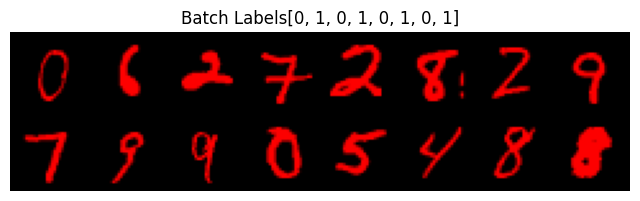

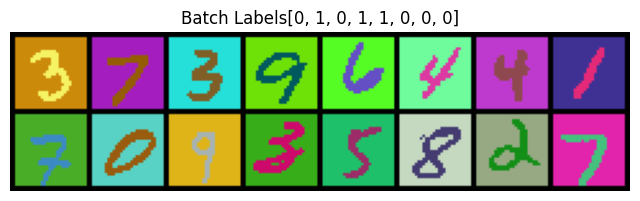

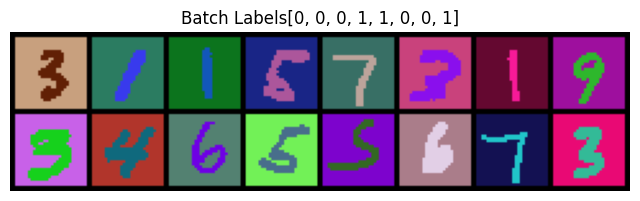

In [3]:

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print("Loading")
train_dataset1=ColoredMNIST(root='./data', env='train1', transform=transform)
train_dataset2= ColoredMNIST(root='./data', env='train2', transform=transform)
train_dataset3= ColoredMNIST(root='./data', env='train3', transform=transform)
test_dataset1= ColoredMNIST(root='./data', env='test1', transform=test_transform)
test_dataset2= ColoredMNIST(root='./data', env='test2', transform=test_transform)

# 打印数据集大小，确认加载成功
print(f"Size of train_dataset_1: {len(train_dataset1)}")
print(f"Size of test_dataset_2: {len(test_dataset2)}")

print(train_dataset1)
see1=next(iter(train_dataset1))
see2=next(iter(test_dataset1))
print(see1[0].shape,see2[0].shape)

from torch.utils.data import DataLoader,ConcatDataset
#把所有训练集搞在一起
#all_train_dataset = ConcatDataset([train_dataset1, train_dataset2, train_dataset3])

BATCH_SIZE = config["batch_size"]
#dataloader

from torch.utils.data import DataLoader,ConcatDataset
#把所有训练集搞在一起
all_train_dataset = ConcatDataset([train_dataset1, train_dataset2, train_dataset3])

my_train_loader = DataLoader(dataset=all_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
my_train_loader1 = DataLoader(dataset=train_dataset1, batch_size=BATCH_SIZE, shuffle=True)
my_train_loader2 = DataLoader(dataset=train_dataset2, batch_size=BATCH_SIZE, shuffle=True)
my_train_loader3 = DataLoader(dataset=train_dataset3, batch_size=BATCH_SIZE, shuffle=True)
my_test_loader1 = DataLoader(dataset=test_dataset1, batch_size=BATCH_SIZE, shuffle=False)
my_test_loader2 = DataLoader(dataset=test_dataset2, batch_size=BATCH_SIZE, shuffle=False)
#all_dataloader=DataLoader(dataset=all_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#print(f"Total training{len(all_train_dataset)}")
print(f"Test1 {len(all_train_dataset)}")
print(f"Test1 {len(test_dataset1)}")
print(f"Test2 {len(test_dataset2)}")
from torch.utils.data import Subset, ConcatDataset, DataLoader
#subset_indices = list(range(int(len(all_train_dataset) * 0.2))) 
# 创建数据子集
#debug_train_dataset = Subset(all_train_dataset, subset_indices)
#debug_dataloader = DataLoader(dataset=debug_train_dataset, batch_size=BATCH_SIZE, shuffle=True)



def denormalize(tensor):
    device = tensor.device
    mean = torch.tensor([0.5, 0.5, 0.5], device=device)
    std = torch.tensor([0.5, 0.5, 0.5], device=device)

    # 3. 使用广播机制进行计算，(C, H, W) -> (C, 1, 1)
    #    这样 (C,H,W) 的张量可以和 (C,1,1) 的张量安全运算
    denormalized_tensor = tensor * std[:, None, None] + mean[:, None, None]
    # 4. 将数值限制在[0, 1]范围
    denormalized_tensor = torch.clamp(denormalized_tensor, 0, 1)
    
    return denormalized_tensor

def show_batch(data_loader):
    # 从数据加载器中获取一个批次的数据
    images, labels = next(iter(data_loader))
    images=images[:16]
    labels=labels[:16]
    #print(images,labels)
    # 逆标准化
    images = denormalize(images)
    # 创建一个图像网格
    # nrow 是每行显示的图片数量
    grid = torchvision.utils.make_grid(images, nrow=8)

    # 将 Tensor 转换为 NumPy 数组并调整维度顺序 (C, H, W) -> (H, W, C)
    np_grid = grid.permute(1, 2, 0).numpy()
    #return
    # 显示图像
    plt.figure(figsize=(8, 3))
    plt.imshow(np_grid)
    plt.title(f'Batch Labels{labels[:8].tolist()}')
    plt.axis('off')
    plt.show()


# 模拟
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

print("看一下数据集的情况")
show_batch(my_train_loader1)
show_batch(my_test_loader1)
show_batch(my_test_loader2)



In [4]:
from torch import nn
from torch.utils import model_zoo
#from torchvision.models.resnet import BasicBlock, model_urls, Bottleneck
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models import ResNet18_Weights, ResNet50_Weights
import torchvision.models as models
import torch
from torch import nn as nn
from torch.autograd import Variable,grad
import numpy.random as npr
import numpy as np
import torch.nn.functional as F
import random
import math
import torch.nn.init as init


#----------------------------------------------------------------------------------
def initialize_lenet_weights(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight) 
        if m.bias is not None:
            init.constant_(m.bias, 0)

class LeNet5RSC(nn.Module):

    def __init__(self, improved:bool,num_classes=2, pecent=config["pecent"],drop_rate=config['drop_rate']):
        super(LeNet5RSC, self).__init__()
        
        
        self.num_classes=num_classes
        self.pecent=pecent 
        self.drop_rate=drop_rate
        self.improved=improved
        # LeNet5 的特征提取部分
        self.features_extractor = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2),
            nn.InstanceNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
#==========================================================================
        
         # Sobel 卷积
        self.sobel_x = nn.Conv2d(3, 3, kernel_size=3, padding=1, bias=False)
        self.sobel_y = nn.Conv2d(3, 3, kernel_size=3, padding=1, bias=False)
        self.init_sobel()

        # 拼接后的融合
        self.edge_fuse_conv = nn.Conv2d(16 + 3, 16, kernel_size=3, padding=1)
        self.edge_fuse_norm = nn.InstanceNorm2d(16)
        
#===========================================================================        
        # LeNet5 的分类器部分
        self.class_classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )
        # 应用初始化
        self.apply(initialize_lenet_weights)
#============================================================================
    
    def init_sobel(self):
        sobel_kernel_x = torch.tensor([[-1., 0., 1.],
                                       [-2., 0., 2.],
                                       [-1., 0., 1.]]).repeat(3,1,1,1)
        sobel_kernel_y = torch.tensor([[-1., -2., -1.],
                                       [ 0.,  0.,  0.],
                                       [ 1.,  2.,  1.]]).repeat(3,1,1,1)
        self.sobel_x.weight.data.copy_(sobel_kernel_x)
        self.sobel_y.weight.data.copy_(sobel_kernel_y)
        for p in self.sobel_x.parameters():
            p.requires_grad = False
        for p in self.sobel_y.parameters():
            p.requires_grad = False
            
#============================================================================
    def forward(self, x, gt=None, flag=None, epoch=None):
        if self.improved:
            edge_x = self.sobel_x(x)
            edge_y = self.sobel_y(x)
            edges = torch.sqrt(edge_x ** 2 + edge_y ** 2 + 1e-6)
            #x:128,3,28,28; gt:128
            feat = self.features_extractor(x) # 原始特征 (B, C, H, W)
            #raw_features:128,16,5,5
            # 拼接边缘信息
            edge_resized = F.interpolate(edges, size=feat.shape[2:], mode='bilinear', align_corners=False)
            fused = torch.cat([feat, edge_resized], dim=1)
            #raw_features = F.relu(self.edge_fuse_conv(fused))
            raw_features = F.relu(self.edge_fuse_norm(self.edge_fuse_conv(fused)))
        else:
            raw_features = self.features_extractor(x) 
        if flag:
            #梯度和重要性计算
            #复制一份模型
            grad_model = self.__class__(improved=self.improved,num_classes=self.num_classes, pecent=self.pecent, drop_rate=self.drop_rate).to(x.device)
            #grad_model = self.__class__(num_classes=self.num_classes, pecent=self.pecent).to(x.device)
            grad_model.load_state_dict(self.state_dict())
            grad_model.train()
            x_new=grad_model.features_extractor(x).requires_grad_(True)#不要直接clone而是从复制的模型构建
            #x_new:128,16,5,5
            #x_new = raw_features.clone().detach().requires_grad_(True)
            x_new.retain_grad()
            x_new_view = x_new.view(x_new.size(0), -1)#LeNet5的分类器直接接收展平特征
            output = grad_model.class_classifier(x_new_view)
            #output:128,2
            class_num = output.shape[1]
            one_hot_sparse = torch.zeros_like(output).scatter_(1, gt.unsqueeze(1), 1)#遍历个行，列的选取按照gt，填充为1，这里构建128*2独热编码
            one_hot = torch.sum(output * one_hot_sparse)
            # 反向传播获取梯度
            grad_model.zero_grad()
            one_hot.backward(retain_graph=True) # retain_graph=True是必需的，因为后续还有计算
            grads_val = x_new.grad.clone().detach()
            #grads_val:128,16,5,5
        
            #计算通道平均梯度
            num_rois, num_channel, H, W = x_new.shape
            HW = H * W #5*5=25
            grad_channel_mean = torch.mean(grads_val.view(num_rois, num_channel, -1), dim=2)
            #grad_channel_mean:128,16,1
            
            #计算空间重要性，使用通道平均梯度乘以原始特征
            channel_weights=torch.mean(grads_val, dim=[2, 3], keepdim=True)
            #channel_weights:128,16,1,1,它强调哪些通道是重要的
            spatial_mean_grad_cam = torch.sum(x_new.detach() * channel_weights, dim=1)
            #spatial_mean_grad_cam = F.relu(spatial_mean_grad_cam)
            spatial_mean = spatial_mean_grad_cam.view(num_rois, HW)
            #spatial_mean:128,25
            #修改处，直接使用梯度的绝对值作为空间重要性
            #spatial_mean = torch.mean(torch.abs(grads_val),dim=1).view(num_rois,HW)
            
            grad_model.zero_grad() #再次清零梯度，因为已经提取了需要的值
            
            #创建掩码矩阵
            #修改处，两者都要，加权，权重硬编码
            #choose_one = random.randint(0, 9)
            #if choose_one <= 4: # 50% 概率空间抑制
            spatial_drop_num = math.ceil(HW * self.drop_rate)
            th18_mask_value = torch.sort(spatial_mean, dim=1, descending=True)[0][:, spatial_drop_num]
            th18_mask_value = th18_mask_value.view(num_rois, 1).expand(num_rois, HW)
            
            mask_cuda = torch.where(spatial_mean > th18_mask_value, 
                                    torch.zeros_like(spatial_mean),
                                    torch.ones_like(spatial_mean))
            mask_space = mask_cuda.reshape(num_rois, H, W).view(num_rois, 1, H, W)
            #else: # 50% 概率通道抑制
            vector_thresh_percent = math.ceil(num_channel * self.drop_rate)
            vector_thresh_value = torch.sort(grad_channel_mean, dim=1, descending=True)[0][:, vector_thresh_percent]
            vector_thresh_value = vector_thresh_value.view(num_rois, 1).expand(num_rois, num_channel)
            
            vector = torch.where(grad_channel_mean > vector_thresh_value,
                                    torch.zeros_like(grad_channel_mean),
                                    torch.ones_like(grad_channel_mean))
            mask_chan = vector.view(num_rois, num_channel, 1, 1)
            mask_all=mask_chan*0.7+mask_space*0.3
            
            #基于置信度变化的掩码修正
            # 1. 计算抑制前后的分类置信度
            cls_prob_before = F.softmax(output, dim=1)
            x_new_view_after = raw_features * mask_all 
            x_new_view_after = x_new_view_after.view(x_new_view_after.size(0), -1)
            x_new_view_after = self.class_classifier(x_new_view_after) # 使用主模型的分类器
            cls_prob_after = F.softmax(x_new_view_after, dim=1)
            # 2. 计算置信度下降程度
            one_hot_sparse_for_prob = torch.zeros_like(cls_prob_before).scatter_(1, gt.unsqueeze(1), 1)
            before_vector = torch.sum(one_hot_sparse_for_prob * cls_prob_before, dim=1)
            after_vector = torch.sum(one_hot_sparse_for_prob * cls_prob_after, dim=1)
            change_vector = before_vector - after_vector - 0.0001
            change_vector = torch.where(change_vector > 0, change_vector, torch.zeros_like(change_vector))
            # 3. 找到置信度下降不显著的样本
            th_fg_value = torch.sort(change_vector, dim=0, descending=True)[0][int(round(float(num_rois) * self.pecent))]
            drop_index_fg = change_vector.gt(th_fg_value)
            ignore_index_fg = ~drop_index_fg
            
            # 4. 对这些样本取消抑制 (将它们的掩码设为 1)
            mask_all[ignore_index_fg, :] = 1

            del grad_model 
            #得到最终的输出
            processed_features = raw_features * mask_all.detach()
        else:
            processed_features = raw_features

        # 重新前向传播
        x = processed_features.view(processed_features.size(0), -1)
        logits = self.class_classifier(x)
        
        return logits,processed_features


In [5]:
#-----------------------------------------------------------------------------
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {my_device}")

def get_optim_and_scheduler(network, epochs, lr=config["lr"], train_all=True, nesterov=False):
    if train_all:
        params = network.parameters()
    else:
        params = network.get_params(lr)
    optimizer = optim.SGD(params, weight_decay=.0005, momentum=0.9, nesterov=nesterov, lr=lr)
    step_size = 5
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size,gamma=0.1)
    print("Step size: %d" % step_size)
    return optimizer, scheduler

NUM_EPOCHS = config["num_epochs"]
my_loss=nn.CrossEntropyLoss()

def test_model(model,test_loader,device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs,_ = model(images)
            _, predicted = torch.max(outputs.data, 1)#取最大概率作为结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validating Accuracy{accuracy:.2f} %')
    return accuracy
def compute_irm_penalty(processed_features_list, labels_list, classifier_head, device):
    """
    计算基于 IRMv1 的梯度不变性惩罚
    processed_features_list: 每个环境经过 RSC 处理后的特征列表
    labels_list: 每个环境的标签列表。
    classifier_head: 模型的分类器部分(nn.Sequential)
    """
    if len(processed_features_list) < 2:
        return torch.tensor(0.0, device=device)

    #LeNet5的分类器输入是16*5*5
    feature_dim = processed_features_list[0].shape[1] * processed_features_list[0].shape[2] * processed_features_list[0].shape[3]
    num_classes = classifier_head[-1].out_features
    
    #虚拟权重，每次调用都重新创建
    dummy_w = torch.randn(num_classes, feature_dim, requires_grad=True, device=device)
    dummy_b = torch.randn(num_classes, requires_grad=True, device=device)

    penalty = 0.0
    for features_e, labels_e in zip(processed_features_list, labels_list):
        # 展平特征
        features_flat_e = torch.flatten(features_e, 1)
        #通过虚拟权重计算logits
        logits_e = F.linear(features_flat_e, dummy_w, dummy_b)
        # 计算该环境的损失
        loss_e = F.cross_entropy(logits_e, labels_e)
        # 计算损失相对于虚拟权重 dummy_w 的梯度
        # create_graph=True允许对梯度本身进行二次求导（即惩罚梯度）
        grad_w_e = grad(loss_e, dummy_w, create_graph=True)[0]
        # 计算梯度范数的平方
        penalty += grad_w_e.pow(2).sum()
        
    return penalty / len(processed_features_list) # 平均惩罚项


#这个还要调整
def visualize_attention_map(model, data_loader, device, image_index=0):
    """
    可视化 LeNet5RSC 模型内部计算出的空间重要性图（注意力图）。
    """
    print(f"\n--- 生成第 {image_index} 张图片的 RSC 空间重要性图 ---")
    model.eval() # 先设置为评估模式，但内部会用克隆模型在训练模式下计算

    # 1. 获取一个批次的图像和标签
    images, labels = next(iter(data_loader))
    single_image = images[image_index].unsqueeze(0).to(device)
    single_label = labels[image_index].unsqueeze(0).to(device)

    # 2. 重演 forward 方法中的梯度和重要性计算逻辑
    #    这部分与 model.forward 内部的 RSC 逻辑完全一致

    # a. 克隆模型
    grad_model = model.__class__(num_classes=model.num_classes, pecent=model.pecent).to(device)
    grad_model.load_state_dict(model.state_dict())
    grad_model.train() # 确保克隆模型在训练模式

    # b. 准备用于梯度的特征图
    x_new = grad_model.features_extractor(single_image).requires_grad_(True)
    x_new.retain_grad()
    # c. 在克隆模型上计算 Logits
    x_new_view = x_new.view(x_new.size(0), -1)
    output = grad_model.class_classifier(x_new_view)
    
    # d. 计算目标 Logit
    one_hot_sparse = torch.zeros_like(output).scatter_(1, single_label.unsqueeze(1), 1)
    one_hot = torch.sum(output * one_hot_sparse)

    # e. 反向传播获取梯度
    grad_model.zero_grad()
    one_hot.backward(retain_graph=True) 
    grads_val = x_new.grad.clone().detach()
    # f. 计算通道平均梯度和空间重要性
    num_rois, num_channel, H, W = x_new.shape
    HW = H * W
    grad_channel_mean = torch.mean(grads_val.view(num_rois, num_channel, -1), dim=2)
    
    # spatial_mean 是我们想要可视化的“注意力图”
    spatial_mean = torch.sum(x_new.detach() * grad_channel_mean.view(num_rois, num_channel, 1, 1), 1)
    
    # 3. 对空间重要性图进行处理以便可视化
    
    # a. 取绝对值，因为正负贡献都代表重要性
    attention_map_raw = torch.abs(spatial_mean)
    
    # b. 移除批次维度 (因为我们只可视化一张图)
    attention_map_squeezed = attention_map_raw.squeeze(0) # 形状 (H, W)
    
    # c. Min-Max 归一化到 [0, 1] 范围，以便 imshow 正确显示颜色
    min_val = attention_map_squeezed.min()
    max_val = attention_map_squeezed.max()
    if (max_val - min_val) > 1e-8:
        attention_heatmap = (attention_map_squeezed - min_val) / (max_val - min_val)
    else:
        attention_heatmap = torch.zeros_like(attention_map_squeezed)

    # 4. 准备原始图像和热图用于绘制
    original_image_to_show = denormalize(single_image.squeeze(0))
    original_image_np = original_image_to_show.cpu().permute(1, 2, 0).numpy()
    attention_heatmap_np = attention_heatmap.cpu().numpy()

    # 5. 绘制
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.imshow(original_image_np)
    ax1.set_title(f'Original Image (Label: {single_label.item()})')
    ax1.axis('off')
    
    im = ax2.imshow(attention_heatmap_np, cmap='hot', interpolation='nearest')
    ax2.set_title('RSC Spatial Importance Heatmap')
    ax2.axis('off')
    fig.colorbar(im, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
    del grad_model # 释放内存

Using device: cuda


# 只使用一个训练环境，除了仅RSC时用改进的模型外，其他都不用

In [6]:
#---------------------------------------------------------------------------------
NUM_EPOCHS=15
from itertools import cycle
def rsc_irm_train(model, train_loaders,test_loader1,test_loader2,loss_fn, optimizer, scheduler,device, num_epochs=NUM_EPOCHS,use_rsc=True, irm_lambda=config['irm_lambda']):
    current_step=0
    if use_rsc:
        print("\nStarting RSC+IRM training")
    else:
        print("\nStarting IRM training")
    print(f"Using improved structure:{model.improved}")
    print(f"Dataloader length:{len(train_loaders)}")
    history = {
        'train_loss': [],
        'train_acc':[],
        'rsc_loss':[],
        'irm_penalty': [],
        'test_acc1':[],
        'test_acc2':[],
        'test_avg':[]
        }
    train_loader_iters = [iter(cycle(loader)) for loader in train_loaders]
    num_batches_per_epoch = max([len(loader) for loader in train_loaders])
    for epoch in range(num_epochs):
        model.train()
        #超参数的动态优化部分
        #源代码的逻辑是每10个epoch更新一次pecent，pecent取消抑制的数量，高pecent只有置信度下降最剧烈的会被真正抑制
        interval = 6
        if epoch > 0 and epoch % interval == 0:
            model.pecent = 3.0 / 10 + (epoch / interval) * 2.0 / 10
            print(f"Epoch {epoch+1}, self.pecent updated to: {model.pecent:.2f}")
        current_irm_lambda = irm_lambda
        if epoch < 10: # 预热期，IRM惩罚较小
            current_irm_lambda = irm_lambda * 0.01 
        elif epoch < 20: # 中期，IRM惩罚增加
            current_irm_lambda = irm_lambda * 0.1
        
        #一个epoch的参数
        running_loss = 0.0
        #n_batches = len(train_loaders)
        n_batches = max(len(loader) for loader in train_loaders)
        running_erm_loss = 0.0
        running_irm_penalty = 0.0
        running_acc=0.0

        for batch_idx in range(num_batches_per_epoch):
            optimizer.zero_grad()
            
            env_features_for_irm = []
            env_labels_for_irm = []
            batch_erm_loss_sum = 0.0
            total_train_batch = 0
            correct_train_batch = 0
            
            for loader_iter in train_loader_iters:
                #print(images.shape)
                images, labels = next(loader_iter)
                images = images.to(device)
                labels = labels.to(device)
                # 前向传播
                outputs,features = model(images,gt=labels, flag=use_rsc, epoch=epoch)
                env_features_for_irm.append(features)
                env_labels_for_irm.append(labels)
                
                # 计算当前环境的ERM损失
                erm_loss_e = loss_fn(outputs, labels)
                batch_erm_loss_sum += erm_loss_e

                # 统计训练准确率
                _, predicted = torch.max(outputs.data, 1)
                total_train_batch += labels.size(0)
                correct_train_batch += (predicted == labels).sum().item()
            #------------------每个环境做完，下面进入batch层面----------------------------
            erm_loss = batch_erm_loss_sum / len(train_loaders)   
            # 计算 IRM 惩罚项
            irm_penalty = compute_irm_penalty(env_features_for_irm, env_labels_for_irm, model.class_classifier, device)
            # 总损失 = 经验风险 + IRM惩罚
            total_loss = erm_loss + current_irm_lambda * irm_penalty 
            total_loss.backward()
            optimizer.step()
            # 统计信息
            running_erm_loss += erm_loss.item()
            running_irm_penalty += irm_penalty.item() 
            running_loss+=total_loss/len(train_loaders)
            batch_acc=correct_train_batch/total_train_batch 
            running_acc+=batch_acc
            #--------------------每个batch做完-----------------------------
        # 计算epoch统计量
        avg_train_loss = running_loss / n_batches
        avg_train_acc = running_acc / n_batches
        avg_erm_loss=running_erm_loss/n_batches
        avg_irm_pen=running_irm_penalty/n_batches
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss:{avg_train_loss:.4f}, "
              f"Train Acc:{100*avg_train_acc:.2f}%, "
              f"Pecent:{model.pecent}, "
              f"Drop_rate:{model.drop_rate}, "
              f"IRM_lambda:{current_irm_lambda}"
             )  
        test_acc1=test_model(model,test_loader1, device)
        test_acc2=test_model(model,test_loader2, device)
        #记录
        history['train_loss'].append(avg_train_loss.item())
        history['train_acc'].append(avg_train_acc)
        history['rsc_loss'].append(avg_erm_loss)
        history['irm_penalty'].append(avg_irm_pen)
        history['test_acc1'].append(test_acc1)
        history['test_acc2'].append(test_acc2)
        history['test_avg'].append((test_acc1 + test_acc2) / 2)
        if epoch%2==0:
            #visualize_attention_map(model, test_loader, my_device, image_index=10)
            pass
        
        scheduler.step()
    print("Finished training")
    return history


In [7]:

#只使用IRM
my_model_irm=LeNet5RSC(improved=False,num_classes=2).to(my_device)
my_optimizer_irm,my_scheduler_irm=get_optim_and_scheduler(my_model_irm,NUM_EPOCHS)
my_history_irm=rsc_irm_train(my_model_irm,[my_train_loader1,my_train_loader2,my_train_loader3],
                             my_test_loader1,my_test_loader2,
                             my_loss,my_optimizer_irm,my_scheduler_irm,my_device,
                             use_rsc=False)



Step size: 5

Starting IRM training
Using improved structure:False
Dataloader length:3
Epoch [1/15], Train Loss:0.1095, Train Acc:87.89%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy70.14 %
Validating Accuracy71.49 %
Epoch [2/15], Train Loss:0.0457, Train Acc:97.00%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy72.89 %
Validating Accuracy73.37 %
Epoch [3/15], Train Loss:0.0368, Train Acc:97.81%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy74.00 %
Validating Accuracy74.03 %
Epoch [4/15], Train Loss:0.0332, Train Acc:98.31%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy73.55 %
Validating Accuracy73.73 %
Epoch [5/15], Train Loss:0.0305, Train Acc:98.60%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy73.80 %
Validating Accuracy73.75 %
Epoch [6/15], Train Loss:0.0252, Train Acc:98.84%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy74.23 %
Validating Accuracy74.22 %
Epoch 7, self

In [75]:
print(my_history_irm)

{'train_loss': [0.24415580928325653, 0.10227074474096298, 0.06866124272346497, 0.052277687937021255, 0.04344438016414642, 0.029226021841168404, 0.025866251438856125, 0.024570079520344734, 0.023613713681697845, 0.0227945726364851, 0.021378809586167336, 0.021208176389336586, 0.021105965599417686, 0.021015452221035957, 0.02093401737511158], 'train_acc': [0.8993829617834395, 0.9628781847133758, 0.9749203821656051, 0.9834792993630573, 0.9865644904458599, 0.9903463375796179, 0.9924363057324841, 0.9930334394904459, 0.993531050955414, 0.9940286624203821, 0.9948248407643312, 0.9950238853503185, 0.9950238853503185, 0.9950238853503185, 0.9950238853503185], 'rsc_loss': [0.24415576917113394, 0.10227070276619522, 0.06866122000097374, 0.05227766820721945, 0.04344438356614322, 0.029226016527587537, 0.02586625096058936, 0.02457008478276218, 0.023613716218365464, 0.022794564454045124, 0.021378805078595735, 0.0212081776862181, 0.021105968202078704, 0.02101545529825625, 0.020934013221234938], 'irm_penalty

In [8]:
#使用IRM+RSC
my_model_irm_rsc=LeNet5RSC(improved=False,num_classes=2).to(my_device)
my_optimizer_irm_rsc,my_scheduler_irm_rsc=get_optim_and_scheduler(my_model_irm_rsc,NUM_EPOCHS)
my_history_irm_rsc=rsc_irm_train(my_model_irm_rsc,[my_train_loader1,my_train_loader2,my_train_loader3],
                                 my_test_loader1,my_test_loader2,
                                 my_loss,my_optimizer_irm_rsc,my_scheduler_irm_rsc,my_device,
                                 use_rsc=True)

Step size: 5

Starting RSC+IRM training
Using improved structure:False
Dataloader length:3
Epoch [1/15], Train Loss:0.1124, Train Acc:87.50%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy70.41 %
Validating Accuracy70.64 %
Epoch [2/15], Train Loss:0.0523, Train Acc:96.28%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy71.44 %
Validating Accuracy71.23 %
Epoch [3/15], Train Loss:0.0421, Train Acc:97.29%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy73.22 %
Validating Accuracy72.54 %
Epoch [4/15], Train Loss:0.0363, Train Acc:97.79%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy72.31 %
Validating Accuracy71.38 %
Epoch [5/15], Train Loss:0.0320, Train Acc:98.17%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy71.80 %
Validating Accuracy72.28 %
Epoch [6/15], Train Loss:0.0280, Train Acc:98.63%, Pecent:0.1, Drop_rate:0.05, IRM_lambda:0.003
Validating Accuracy72.34 %
Validating Accuracy72.44 %
Epoch 7, 

In [9]:
NUM_EPOCHS = 15 # 训练epoch

def train(model,train_loader,loss,optimizer,device,train_test1,train_test2,use_rsc=True):
    if use_rsc:
        print("\nStarting RSC training")
    else:
        print("\nStarting Normal training")
    print(f"Using improved structure:{model.improved}")
    print(f"Dataloader length: 1")
    history = {
    'train_loss': [],
    'train_acc': [],
    'test_acc1':[],
    'test_acc2':[],
    'test_avg':[]
    }
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss=0.0
        total_train=correct_train=0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            #outputs = model(images)
            outputs,features = model(images, gt=labels, flag=use_rsc, epoch=epoch)
            loss1 = loss(outputs, labels)
            optimizer.zero_grad()
            loss1.backward()
            optimizer.step()
            running_loss += loss1.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        print("comes test1")    
        test_acc1=test_model(model,train_test1, device)
        print("comes test2")    
        test_acc2=test_model(model,train_test2, device)
        
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc1'].append(test_acc1)
        history['test_acc2'].append(test_acc2)
        history['test_avg'].append((test_acc1 + test_acc2) / 2)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}],Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print("Finished")
    return history


In [10]:

#只用RSC，不提高
my_model_rsc=LeNet5RSC(num_classes=2,improved=False).to(my_device)
my_optimizer_rsc,my_scheduler_rsc=get_optim_and_scheduler(my_model_rsc,NUM_EPOCHS)
my_history_rsc=train(my_model_rsc,my_train_loader,my_loss,my_optimizer_rsc,my_device,my_test_loader1,my_test_loader2,use_rsc=True)


Step size: 5

Starting RSC training
Using improved structure:False
Dataloader length: 1
comes test1
Validating Accuracy76.51 %
comes test2
Validating Accuracy76.87 %
Epoch [1/15],Train Loss: 0.1753, Train Acc: 92.46%
comes test1
Validating Accuracy74.26 %
comes test2
Validating Accuracy74.39 %
Epoch [2/15],Train Loss: 0.0682, Train Acc: 97.58%
comes test1
Validating Accuracy79.65 %
comes test2
Validating Accuracy80.02 %
Epoch [3/15],Train Loss: 0.0524, Train Acc: 98.11%
comes test1
Validating Accuracy80.53 %
comes test2
Validating Accuracy80.17 %
Epoch [4/15],Train Loss: 0.0402, Train Acc: 98.60%
comes test1
Validating Accuracy76.91 %
comes test2
Validating Accuracy78.06 %
Epoch [5/15],Train Loss: 0.0340, Train Acc: 98.82%
comes test1
Validating Accuracy79.87 %
comes test2
Validating Accuracy80.19 %
Epoch [6/15],Train Loss: 0.0304, Train Acc: 98.93%
comes test1
Validating Accuracy78.87 %
comes test2
Validating Accuracy79.00 %
Epoch [7/15],Train Loss: 0.0292, Train Acc: 98.96%
comes tes

In [11]:
#只用RSC，提高
my_model_rsc_imp=LeNet5RSC(num_classes=2,improved=True).to(my_device)
my_optimizer_rsc_imp,my_scheduler_rsc_imp=get_optim_and_scheduler(my_model_rsc_imp,NUM_EPOCHS)
my_history_rsc_imp=train(my_model_rsc_imp,my_train_loader,my_loss,my_optimizer_rsc_imp,my_device,my_test_loader1,my_test_loader2,use_rsc=True)


Step size: 5

Starting RSC training
Using improved structure:True
Dataloader length: 1
comes test1
Validating Accuracy75.09 %
comes test2
Validating Accuracy75.12 %
Epoch [1/15],Train Loss: 0.1627, Train Acc: 93.32%
comes test1
Validating Accuracy73.27 %
comes test2
Validating Accuracy73.09 %
Epoch [2/15],Train Loss: 0.0614, Train Acc: 97.77%
comes test1
Validating Accuracy76.74 %
comes test2
Validating Accuracy76.35 %
Epoch [3/15],Train Loss: 0.0449, Train Acc: 98.41%
comes test1
Validating Accuracy76.33 %
comes test2
Validating Accuracy76.67 %
Epoch [4/15],Train Loss: 0.0337, Train Acc: 98.74%
comes test1
Validating Accuracy78.45 %
comes test2
Validating Accuracy79.15 %
Epoch [5/15],Train Loss: 0.0281, Train Acc: 99.00%
comes test1
Validating Accuracy77.82 %
comes test2
Validating Accuracy78.19 %
Epoch [6/15],Train Loss: 0.0233, Train Acc: 99.16%
comes test1
Validating Accuracy76.97 %
comes test2
Validating Accuracy76.58 %
Epoch [7/15],Train Loss: 0.0183, Train Acc: 99.37%
comes test

In [12]:
#baseline
my_model_none=LeNet5RSC(num_classes=2,improved=False).to(my_device)
my_optimizer_none,my_scheduler_none=get_optim_and_scheduler(my_model_none,NUM_EPOCHS)
my_history_none=train(my_model_none,my_train_loader,my_loss,my_optimizer_none,my_device,my_test_loader1,my_test_loader2,use_rsc=False)

Step size: 5

Starting Normal training
Using improved structure:False
Dataloader length: 1
comes test1
Validating Accuracy73.95 %
comes test2
Validating Accuracy73.29 %
Epoch [1/15],Train Loss: 0.1626, Train Acc: 93.24%
comes test1
Validating Accuracy74.08 %
comes test2
Validating Accuracy74.31 %
Epoch [2/15],Train Loss: 0.0638, Train Acc: 97.79%
comes test1
Validating Accuracy71.39 %
comes test2
Validating Accuracy71.53 %
Epoch [3/15],Train Loss: 0.0449, Train Acc: 98.47%
comes test1
Validating Accuracy74.38 %
comes test2
Validating Accuracy73.73 %
Epoch [4/15],Train Loss: 0.0365, Train Acc: 98.77%
comes test1
Validating Accuracy72.94 %
comes test2
Validating Accuracy73.75 %
Epoch [5/15],Train Loss: 0.0312, Train Acc: 98.93%
comes test1
Validating Accuracy75.17 %
comes test2
Validating Accuracy75.33 %
Epoch [6/15],Train Loss: 0.0271, Train Acc: 99.07%
comes test1
Validating Accuracy73.32 %
comes test2
Validating Accuracy73.31 %
Epoch [7/15],Train Loss: 0.0238, Train Acc: 99.19%
comes 

In [31]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    if history['train_acc'][0]<1:
        for i in range(len(history['train_acc'])):
            history['train_acc'][i]*=100
    plt.figure(figsize=(10,3))

    # ============== 损失曲线 ==============
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    # ============== 准确率曲线 ==============
    plt.subplot(1,2,2)
    
    plt.plot(epochs, history['train_acc'], 'g-o', label='Training Acc')
    plt.plot(epochs, history['test_acc1'], 'r-s', label='Validating Acc1')
    plt.plot(epochs, history['test_acc2'], 'c-^', label='Validating Acc2')
    plt.plot(epochs, history['test_avg'], 'm-+', label='Test Avg')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def compare_histories(histories, labels=None, metric='test_avg', colors=None):
    """
    histories: list of dict
    labels: list of str
    metric: str
    colors: list of str (比如 ['blue', 'red', 'green'])
    """
    plt.figure(figsize=(10,5))
    if labels is None:
        labels = [f'Model {i+1}' for i in range(len(histories))]
    if colors is None:
        # 使用一个默认颜色序列
        colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown']
    markers = ['o', 's', '^', 'D', 'X', '*']  # 提供不同 marker
    
    for i, (hist, label) in enumerate(zip(histories, labels)):
        epochs = range(1, len(hist[metric]) + 1)
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        plt.plot(epochs, hist[metric], color=color, marker=marker, label=label)
    
    plt.xlabel('Epoch')
    plt.ylabel('Average Validating Accuracy(%)')
    #plt.title('Validating_Average_Accuracy(%)')
    plt.legend()
    plt.grid(True)
    plt.show()

RSC improved


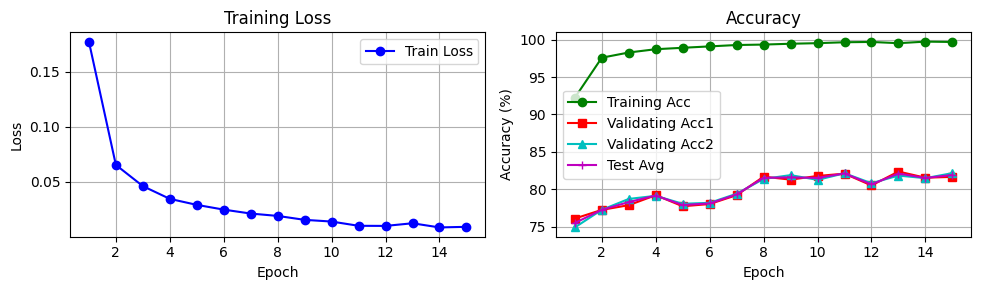

Baseline:


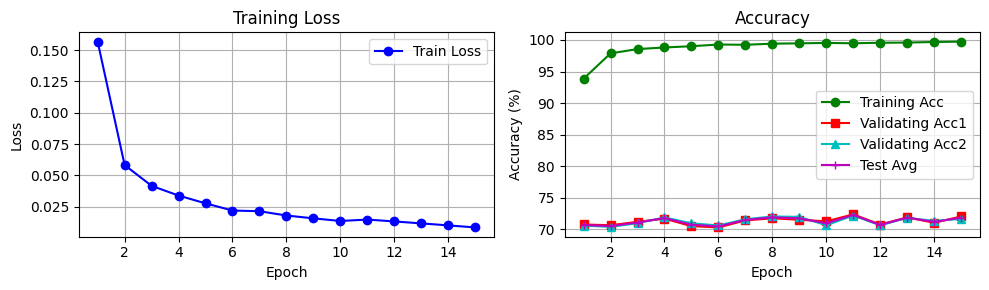

In [27]:
print('RSC improved')
plot_history(my_history_rsc_imp)
print('Baseline:')
plot_history(my_history_none)

irm:


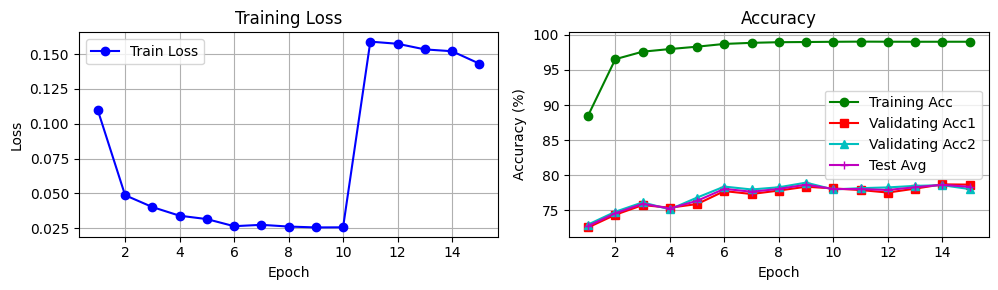

[88.50849256900216, 96.53662420382156, 97.60483014862001, 97.97969745222937, 98.31807324840767, 98.70952760084924, 98.86544585987262, 98.95501592356688, 98.98155520169851, 99.0147292993631, 99.03795116772822, 99.02468152866241, 99.01804670912952, 99.02136411889599, 99.02136411889599]
irm+rsc:


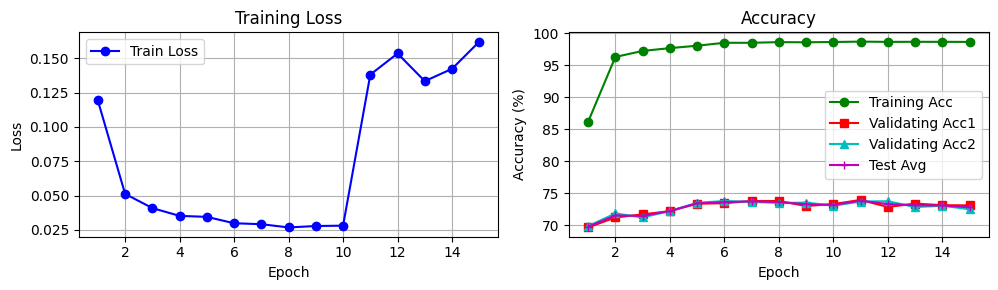

In [34]:
print('irm:')
plot_history(my_history_irm)
print(my_history_irm['train_acc'])
print('irm+rsc:')
plot_history(my_history_irm_rsc)

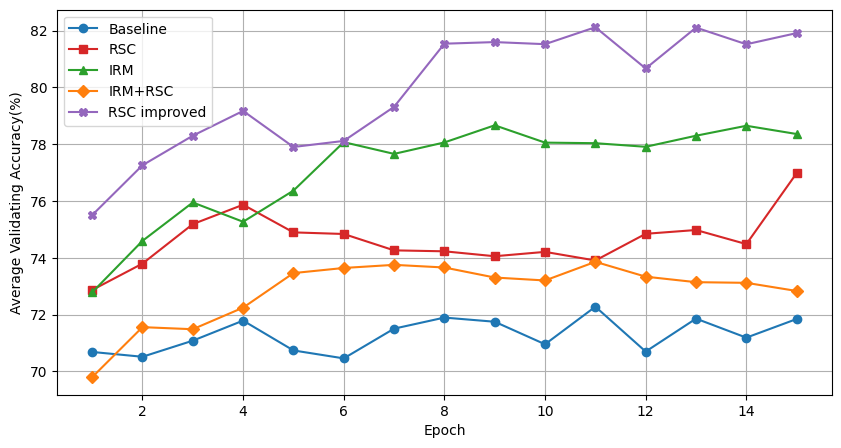

In [32]:
compare_histories(
    [my_history_none, my_history_rsc, my_history_irm,my_history_irm_rsc,my_history_rsc_imp],
    labels=['Baseline', 'RSC', 'IRM', 'IRM+RSC','RSC improved']
)


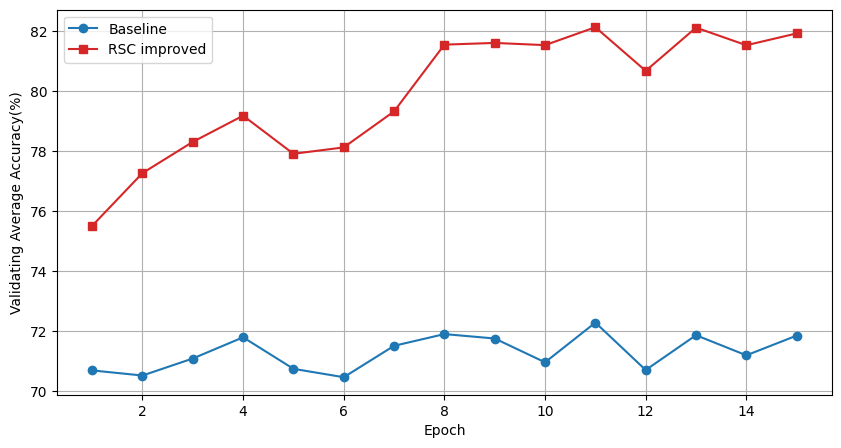

In [30]:
compare_histories(
    [my_history_none, my_history_rsc_imp],
    labels=['Baseline', 'RSC improved']
)